# Análisis de Series Temporales — TP: Linear Predictive Coding (LPC)

**Objetivo.** Implementar el flujo de trabajo del TP de LPC sobre el audio `estocastico.wav`: carga y escucha del audio, marcado de segmentos (vocales), y preparación para estimar LPC por ventana. El guion sigue el enunciado del TP (sección *Introducción*, *Producción del habla* y *Ejercicios 1–2*). :contentReference[oaicite:0]{index=0}

**Datos y utilidades.**
- Audio: `data/estocastico.wav` en tu Google Drive.
- Utilidad interactiva para recortar segmentos: `recorte.py` (función `recortar`). :contentReference[oaicite:1]{index=1}

---

## Ejercicio 1 Utilizando load (librosa), cargar el archivo de audio estocastico. wav y escucharlo utilizando Audio (IPython.display).

Vamos a:
1. Montar Google Drive.
2. Apuntar a la carpeta `data` donde está `estocastico.wav`.
3. Cargar el audio con `librosa.load` y escucharlo con `IPython.display.Audio`.

In [2]:
# --- Montar Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# --- Rutas ---
AUDIO_PATH = '/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data/estocastico.wav'

# --- Carga y escucha ---
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

y, fs = librosa.load(AUDIO_PATH)
print(f'Fs = {fs} Hz, muestras = {len(y)}, duración ≈ {len(y)/fs:.2f} s')

# Audio embebido
ipd.Audio(y, rate=fs)


Fs = 22050 Hz, muestras = 44100, duración ≈ 2.00 s


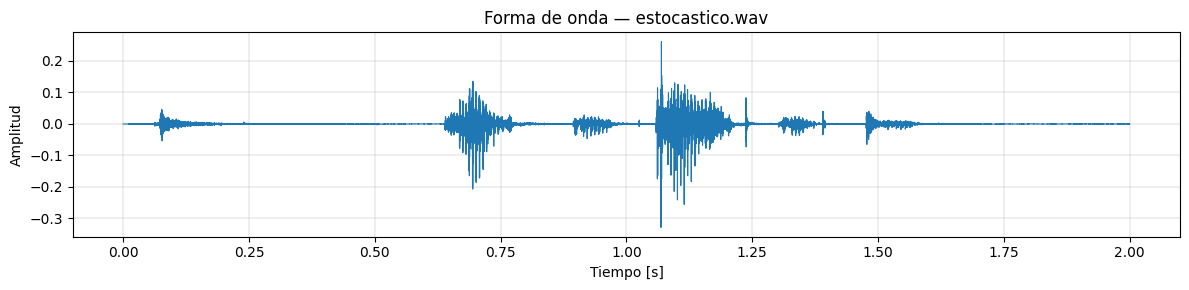

In [4]:
# Forma de onda en función del tiempo (segundos)
t = np.arange(len(y)) / fs
plt.figure(figsize=(12, 3))
plt.plot(t, y, linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Forma de onda — estocastico.wav')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

## Ejercicio 2 Determinar aproximadamente los instantes de tiempo donde se pronuncian las vocales en el audio estocastico. wav . La función recortar de recorte. py puede ser útil.

Vamos a:
1. Visualizar la forma de onda para ubicar regiones de interés (vocales).
2. Para **determinar aproximadamente** los instantes donde se pronuncian las vocales, usamos la herramienta interactiva `recortar` (dos deslizadores que fijan *inicio* y *fin*, botón para **reproducir** el segmento y botón para **guardar** el marcador).

In [7]:
# En Colab, aseguremos soporte de widgets (suele venir activo)
from google.colab import output
output.enable_custom_widget_manager()

# Importar la utilidad recortar
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data')

from recorte import recortar  # ← provisto por la cátedra

# Interfaz interactiva para marcar segmentos (devuelve lista de (inicio, fin) en muestras)
markers = recortar(y, fs)


FloatSlider(value=5000.0, description='Inicio:', max=39100.0, min=5000.0, step=100.0)

FloatSlider(value=6000.0, description='Fin:', max=39100.0, min=5000.0, step=100.0)

Button(description='Reproducir segmento', style=ButtonStyle())

Button(description='Agregar marcador', style=ButtonStyle())

Output()

In [10]:
# Al finalizar, la lista "markers" tendrá pares (inicio, fin) seleccionados.
markers

[(15300.0, 15900.000000000002),
 (21100.0, 21700.0),
 (24900.0, 25500.000000000004),
 (29300.0, 29900.000000000004),
 (33400.0, 34000.0)]

A partir de aquí, una vez guardados los segmentos de vocales en `markers`,
continuaremos con el flujo de LPC por ventanas, calculando autocorrelaciones sesgadas, tal como se describe en el TP.

## Ejercicio 3 Utilizando correlate (numpy) implementar una función que calcule los coeficientes LPC de una señal (representativa de un solo sonido) para N > M.

### Función `lpc_acf(x, M)` — Cálculo de coeficientes LPC por autocorrelación (Yule–Walker)

**Objetivo.** Estimar los coeficientes LPC de un **segmento corto** que representa **una sola vocal**, usando la **autocorrelación** calculada con `numpy.correlate`. Se asume \(N > M\) (longitud del segmento mayor que el orden del modelo).

**Modelo adoptado (AR/LPC):**

$$
x[n] + \sum_{k=1}^{M} a_k\,x[n-k] = e[n]
\quad\Longleftrightarrow\quad
A(z) = 1 + a_1 z^{-1} + \cdots + a_M z^{-M}.
$$

---

**Pasos del método (autocorrelación / Yule–Walker):**

1. **Centrado del segmento:**

   $$
   \tilde{x}[n] = x[n] - \bar{x}.
   $$

2. **Autocorrelación** con `np.correlate` (modo `full`) y se toman los lags  
   \( r[0], r[1], \dots, r[M] \).

   - Opción *biased*: dividir por \(N\) para que \(R\) sea bien condicionada.

3. **Matriz de Toeplitz:**

   $$
   R_{ij} = r[|i-j|], \quad \text{dimensión } M \times M.
   $$

4. **Ecuaciones de Yule–Walker:**

   $$
   R \, \mathbf{a} = - \mathbf{r}_{1:M},
   $$

   donde

   $$
   \mathbf{r}_{1:M} = \begin{bmatrix} r[1] \\ r[2] \\ \vdots \\ r[M] \end{bmatrix}.
   $$

   Se resuelve para

   $$
   \mathbf{a} = \begin{bmatrix} a_1 \\ a_2 \\ \vdots \\ a_M \end{bmatrix}.
   $$

5. **Varianza del error:**

   $$
   \sigma_e^2 = r[0] + \sum_{k=1}^M a_k \, r[k].
   $$

---

**Entradas.**
- `x` : array 1D con el segmento (una vocal).
- `M` : orden del modelo LPC.
- `biased` : si `True`, autocorrelación sesgada (divide por \(N\)).

**Salidas.**
- `a_poly` : polinomio \(A(z)=[1, a_1,\ldots,a_M]\).
- `a` : coeficientes \([a_1,\ldots,a_M]\).
- `err_var` : varianza del error de predicción \(\sigma_e^2\).
- `r` : autocorrelación usada \([r[0],\ldots,r[M]]\).

**Observación.** Este es el **método clásico de autocorrelación**. Para señales de voz, suele preferirse la versión sesgada para que \(R\) sea definida positiva y la solución sea estable.

In [11]:
# -- Función LPC por autocorrelación (usando numpy.correlate) --
import numpy as np

def lpc_acf(x, M, biased=True):
    """
    Coeficientes LPC por método de autocorrelación (Yule–Walker),
    calculando r[k] con numpy.correlate. Requiere N > M.

    Modelo AR/LPC adoptado:
        x[n] + sum_{k=1}^M a_k x[n-k] = e[n]
    => Polinomio del filtro de predicción: A(z) = 1 + a1 z^-1 + ... + aM z^-M

    Parámetros
    ----------
    x : array_like
        Señal (segmento monofónico, una vocal). Se centrará (quita media).
    M : int
        Orden LPC (número de coeficientes a_k).
    biased : bool
        Si True, usa autocorrelación sesgada (divide por N); si False, no divide.

    Devuelve
    --------
    a_poly : ndarray shape (M+1,)
        Coeficientes del polinomio A(z) con a_poly[0] = 1.
    a : ndarray shape (M,)
        Coeficientes a_k (sin el 1 inicial).
    err_var : float
        Varianza del error de predicción: σ_e^2 = r[0] + sum_{k=1}^M a_k r[k].
    r : ndarray shape (M+1,)
        Autocorrelación r[0..M] usada.

    Notas
    -----
    Ecuaciones de Yule–Walker (método de autocorrelación):
        R a = -r_vec,  con R_{ij} = r[|i-j|],  r_vec = [r[1],...,r[M]]^T
        a = - R^{-1} r_vec
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N <= M:
        raise ValueError(f"Se requiere N>M. Recibido N={N}, M={M}.")

    # centrar (recomendado para LPC)
    x = x - np.mean(x)

    # autocorrelación con np.correlate (full), tomar lags 0..M
    r_full = np.correlate(x, x, mode='full')            # tamaño 2N-1
    mid = N - 1
    r = r_full[mid:mid+M+1].copy()                      # r[0..M]
    if biased:
        r /= N

    # armar matriz de Toeplitz R (M x M) y vector r_vec (M,)
    R = np.empty((M, M), dtype=float)
    for i in range(M):
        for j in range(M):
            R[i, j] = r[abs(i - j)]
    r_vec = r[1:M+1]

    # resolver R a = -r_vec
    a = -np.linalg.solve(R, r_vec)

    # varianza del error de predicción
    err_var = float(r[0] + np.dot(r[1:M+1], a))

    # polinomio A(z) = [1, a1, ..., aM]
    a_poly = np.concatenate(([1.0], a))
    return a_poly, a, err_var, r

In [12]:
# -- Ejemplo con los markers de "estocástico" --
M = 10  # orden LPC de ejemplo (ajustá según lo que pidan)

lpc_resultados = []
for i, (ini, fin) in enumerate(markers, start=1):
    seg = y[int(ini):int(fin)]
    a_poly, a, err_var, r = lpc_acf(seg, M=M, biased=True)
    lpc_resultados.append((i, len(seg), a_poly, err_var))
    print(f"Vocal {i}: N={len(seg)}, σ_e^2={err_var:.4e}")
    print("A(z) =", a_poly, "\n")

Vocal 1: N=600, σ_e^2=1.1898e-04
A(z) = [ 1.         -1.72571945  1.21882525 -0.45170245  0.23555649 -0.01096854
 -0.1141852  -0.20122923  0.2507672  -0.17175298  0.04978925] 

Vocal 2: N=600, σ_e^2=8.7004e-07
A(z) = [ 1.         -1.65848158  0.88991668 -0.23528404  0.06705066 -0.06123145
  0.16525138 -0.23636984  0.08595356  0.1692948  -0.08002979] 

Vocal 3: N=600, σ_e^2=9.7663e-05
A(z) = [ 1.         -1.75078028  1.45778778 -0.60737395 -0.20048454  0.61105932
 -0.22403301 -0.29046195  0.40469975 -0.19990981  0.0636687 ] 

Vocal 4: N=600, σ_e^2=7.3000e-06
A(z) = [ 1.         -1.21343577  0.47021391 -0.28632519  0.23413607  0.10276089
 -0.00614528 -0.3388027  -0.07965809  0.03009734  0.13531438] 

Vocal 5: N=600, σ_e^2=2.2836e-06
A(z) = [ 1.         -1.01854472  0.37034366 -0.36859109  0.02705256 -0.25617335
  0.35606764 -0.40862287  0.56057161 -0.20120734  0.07774645] 



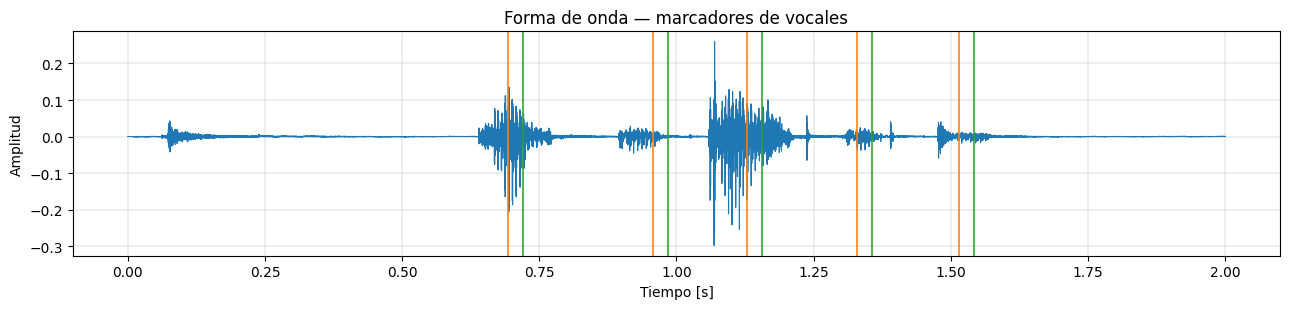

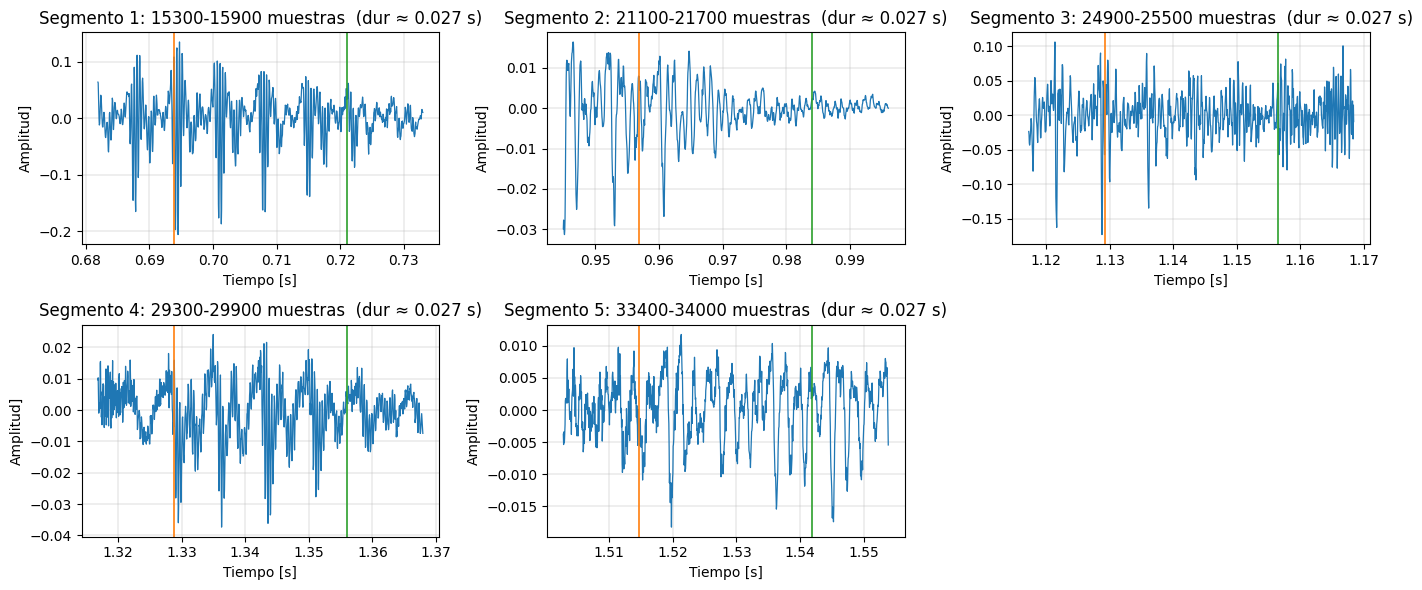

In [14]:
# Graficamos los segmentos para verificar

def plot_wave_with_segments(y, fs, markers, expand_ms=10):
    """
    Grafica la forma de onda completa y marca cada segmento (inicio/fin).
    Luego, hace subplots con zoom para cada segmento (con margen expand_ms).
    """
    t = np.arange(len(y)) / fs

    # --- Vista global ---
    plt.figure(figsize=(13, 3.2))
    plt.plot(t, y, linewidth=0.8)
    for (s, e) in markers:
        plt.axvline(s/fs, color='C1', linewidth=1.5, alpha=0.8)
        plt.axvline(e/fs, color='C2', linewidth=1.5, alpha=0.8)
    plt.title('Forma de onda — marcadores de vocales')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

    # --- Zoom por segmento ---
    nseg = len(markers)
    ncols = min(3, nseg)
    nrows = int(np.ceil(nseg / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.0*nrows), squeeze=False)
    axes = axes.ravel()

    expand = int(expand_ms * 1e-3 * fs)  # margen en muestras
    for i, (s, e) in enumerate(markers):
        s = int(s); e = int(e)
        s0 = max(0, s - expand)
        e0 = min(len(y), e + expand)

        ti = np.arange(s0, e0) / fs
        axes[i].plot(ti, y[s0:e0], linewidth=0.9)
        axes[i].axvline(s/fs, color='C1', linewidth=1.2)
        axes[i].axvline(e/fs, color='C2', linewidth=1.2)
        axes[i].set_title(f'Segmento {i+1}: {s}-{e} muestras  (dur ≈ {(e-s)/fs:.3f} s)')
        axes[i].set_xlabel('Tiempo [s]')
        axes[i].set_ylabel('Amplitud]')
        axes[i].grid(True, linewidth=0.3)

    # ocultar ejes sobrantes si los hay
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Llamada
plot_wave_with_segments(y, fs, markers, expand_ms=12)

## Ejercicio 4 — Respuesta impulsiva del **predictor LPC** (derivación analítica)

**Enunciado.** Dados los coeficientes LPC (orden \(M\)) de un segmento de voz, hallar **analíticamente** la respuesta impulsiva \(h_f[t]\) de un sistema LTI tal que, con entrada \(y[t]\) (la señal del segmento), la salida sea la **predicción lineal** $\hat{x}[t]$:

$$
\hat{x}[t] \;=\; (y * h_f)[t].
$$

---

### 1) Modelo LPC (AR) adoptado
El modelo AR/LPC de orden \(M\) se escribe como:

$$
x[n] + \sum_{k=1}^{M} a_k\, x[n-k] \;=\; e[n],
$$

donde \(e[n]\) es el **error (residuo) de predicción** y $\{a_k\}$ son los coeficientes LPC.

La **predicción lineal a un paso** es:

$$
\hat{x}[n] \;=\; -\sum_{k=1}^{M} a_k\, x[n-k].
$$

---

### 2) Expresar la predicción como convolución
Queremos un sistema LTI con respuesta impulsiva \(h_f[n]\) tal que:

$$
\hat{x}[n] \;=\; (y*h_f)[n] \;=\; \sum_{m=-\infty}^{\infty} y[m]\,h_f[n-m]
\;=\; \sum_{k=-\infty}^{\infty} y[n-k]\,h_f[k].
$$

Comparando con la forma de la predicción:

$$
\hat{x}[n] \;=\; -\sum_{k=1}^{M} a_k\, y[n-k],
$$

se concluye que basta elegir un **FIR causal** de orden \(M\) con coeficientes:

$$
h_f[0]=0, \qquad
h_f[k] = -a_k \quad \text{para } k=1,\dots,M, \qquad
h_f[k]=0 \ \ \text{si } k\notin\{0,1,\dots,M\}.
$$

**Por lo tanto:**

$$
h_f[n] \;=\; -\sum_{k=1}^{M} a_k\, \delta[n-k],
$$

y en dominio-\(z\):

$$
H_f(z) \;=\; \mathcal{Z}\{h_f[n]\} \;=\; -\sum_{k=1}^{M} a_k\, z^{-k}.
$$

---

### 3) Verificación rápida
Con esa \(h_f\):

$$
(y*h_f)[n] \;=\; \sum_{k=1}^{M} (-a_k)\,y[n-k]
\;=\; -\sum_{k=1}^{M} a_k\, x[n-k]
\;=\; \hat{x}[n],
$$

como se quería.

---

### 4) Relación con filtros de **análisis** y **síntesis** LPC
Define el **filtro de análisis** (blanqueo):

$$
A(z) \;=\; 1 + \sum_{k=1}^{M} a_k\, z^{-k}.
$$

Entonces:

$$
e[n] \;=\; A(z)\,x[n],
\qquad
\hat{x}[n] \;=\; x[n] - e[n].
$$

Reescribiendo:

$$
\hat{x}[n] \;=\; \big(1 - A(z)\big)\,x[n]
\;=\; \underbrace{-\sum_{k=1}^{M} a_k z^{-k}}_{H_f(z)}\,x[n].
$$

Esto confirma que el **predictor** es un FIR con función de transferencia:

$$
H_f(z) \;=\; -\sum_{k=1}^{M} a_k z^{-k}.
$$

---

### 5) Conclusión
La respuesta impulsiva del sistema LTI que genera la **predicción LPC** $\hat{x}[t]$ a partir de la señal \(y[t]\) es:

$$
h_f[t] = -\sum_{k=1}^{M} a_k\, \delta[t-k],
$$

un **FIR causal** de orden \(M\) cuyos coeficientes son los LPC con signo cambiado y sin término en \(t=0\).

## Ejercicio 5 — Estimación de la frecuencia de excitación usando `convolve`

**Idea**  
Conocidos los coeficientes LPC $\{a_k\}_{k=1}^M$, el **predictor LPC** del Ejercicio 4 tiene respuesta impulsiva:

$$
h_f[n] = -\sum_{k=1}^M a_k \, \delta[n-k]
$$

y el **filtro de análisis** (o blanqueo) es:

$$
A(z) = 1 + \sum_{k=1}^M a_k z^{-k}
$$

Aplicando $A(z)$ a la señal $y[n]$, obtenemos el **residuo de predicción**:

$$
e[n] = (y * a_{\text{poly}})[n], \quad a_{\text{poly}} = [1, a_1, \ldots, a_M]
$$

Como \(e[n]\) aproxima la **excitación glotal**, su autocorrelación presenta un **pico en el período de pitch** (para voz sonora).  
Entonces la frecuencia fundamental se estima como:

$$
\hat{f}_0 = \frac{f_s}{\arg \max_{\ell \in \mathcal{L}} \, \mathrm{ACF}_e[\ell]}
$$

restringiendo $\mathcal{L}$ al rango plausible de períodos (ejemplo: 80–350 Hz).

In [16]:
# -------------------------------
# Ejercicio 5: estimar f0 (pitch) desde LPC usando CONVOLVE
# -------------------------------

def estimate_pitch_from_lpc(y, a_poly, fs, fmin=80.0, fmax=350.0):
    """
    Estima la frecuencia de excitación (f0) a partir de la señal y[n]
    y los coeficientes LPC (polinomio a_poly = [1, a1, ..., aM]).
    1) Residuo e[n] = (y * a_poly)[n]   (convolve -> "same")
    2) ACF del residuo y búsqueda de pico en el rango [fs/fmax, fs/fmin]

    Parámetros
    ----------
    y : array_like
        Señal (segmento de una vocal). Mejor si viene centrada; aquí se centra.
    a_poly : array_like (M+1,)
        Polinomio de análisis LPC: [1, a1, ..., aM].
    fs : float
        Frecuencia de muestreo (Hz).
    fmin, fmax : float
        Rango plausible de f0 (Hz).

    Devuelve
    --------
    f0_hat : float or None
        Estimación de la frecuencia fundamental (Hz). None si no se encuentra pico válido.
    lag_peak : int or None
        Lag del pico usado (muestras).
    e : ndarray
        Residuo de predicción.
    acf : ndarray
        Autocorrelación no normalizada del residuo (lags >= 0).
    """
    y = np.asarray(y, dtype=float)
    y = y - np.mean(y)

    # Residuo de predicción (convolve como filtrado FIR con A(z))
    e = np.convolve(y, a_poly, mode="same")

    # ACF del residuo (usamos correlate "full" y nos quedamos con lags no negativos)
    acf_full = np.correlate(e, e, mode="full")
    mid = len(acf_full) // 2
    acf = acf_full[mid:]  # lags 0..N-1

    # Rango de lags asociado al rango de f0
    lag_min = max(1, int(np.floor(fs / fmax)))
    lag_max = min(len(acf) - 1, int(np.ceil(fs / fmin)))
    if lag_max <= lag_min:
        return None, None, e, acf

    # Buscamos el pico en ese rango (ignoramos lag 0)
    roi = acf[lag_min:lag_max + 1]
    if roi.size == 0 or np.all(roi <= 0):
        return None, None, e, acf

    k_rel = int(np.argmax(roi))
    lag_peak = lag_min + k_rel
    f0_hat = fs / lag_peak if lag_peak > 0 else None

    return f0_hat, lag_peak, e, acf

### Ejemplo de prueba de la función `estimate_pitch_from_lpc`

Vamos a probar la función implementada para estimar la frecuencia fundamental `f0` de un segmento de la señal.  
Pasos:
1. Seleccionar un segmento de la señal de audio (por ejemplo, la primera vocal recortada con `markers`).  
2. Calcular los coeficientes LPC con el orden `M` elegido.  
3. Llamar a la función `estimate_pitch_from_lpc` y graficar:
   - La señal del residuo `e[n]`.  
   - Su autocorrelación (ACF).  
   - Indicar visualmente el pico que corresponde al período de pitch.

Frecuencia fundamental estimada: 103.90 Hz (lag = 154)


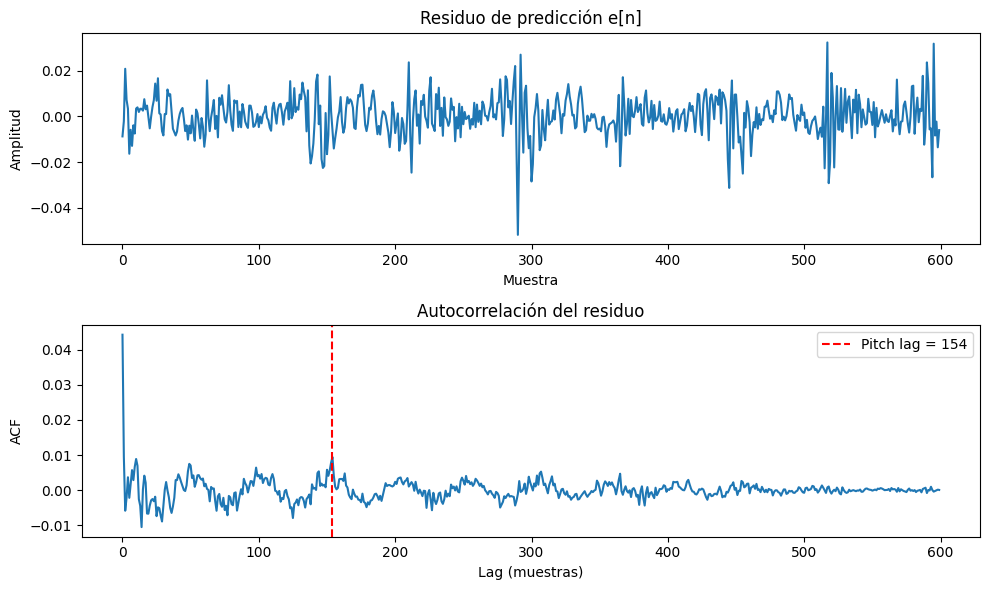

In [17]:
# Ejemplo

# --- Parámetros de prueba ---
M = 12  # orden del modelo LPC
fs = 16000  # frecuencia de muestreo del audio cargado

# Seleccionamos un segmento (ejemplo: la primera vocal de 'estocastico')
start, end = markers[0]  # del primer par guardado en markers
segment = y[int(start):int(end)]

# Estimamos coeficientes LPC (por ejemplo, usando numpy.linalg.lstsq)
# Construimos la matriz de autocorrelación y resolvemos Yule-Walker
r = np.correlate(segment, segment, mode="full")
mid = len(r) // 2
r = r[mid:mid+M+1]

R = np.array([[r[abs(i-j)] for j in range(M)] for i in range(M)])
rhs = -r[1:M+1]
a = np.linalg.solve(R, rhs)
a_poly = np.concatenate(([1], a))

# --- Aplicamos la función del Ej. 5 ---
f0_hat, lag_peak, e, acf = estimate_pitch_from_lpc(segment, a_poly, fs)

print(f"Frecuencia fundamental estimada: {f0_hat:.2f} Hz (lag = {lag_peak})")

# --- Gráficos ---
fig, axs = plt.subplots(2, 1, figsize=(10,6))

# Señal del residuo
axs[0].plot(e)
axs[0].set_title("Residuo de predicción e[n]")
axs[0].set_xlabel("Muestra")
axs[0].set_ylabel("Amplitud")

# Autocorrelación
lags = np.arange(len(acf))
axs[1].plot(lags, acf)
axs[1].axvline(lag_peak, color="red", linestyle="--", label=f"Pitch lag = {lag_peak}")
axs[1].legend()
axs[1].set_title("Autocorrelación del residuo")
axs[1].set_xlabel("Lag (muestras)")
axs[1].set_ylabel("ACF")

plt.tight_layout()
plt.show()

### Conclusión — Ejercicio 5  

En la figura se muestran dos gráficos obtenidos al aplicar el método de predicción LPC para estimar la frecuencia de excitación:  

1. **Residuo de predicción e[n]:**  
   El residuo se comporta como una señal centrada en torno a cero, donde aparecen patrones periódicos que corresponden a la excitación glotal de la vocal analizada.  

2. **Autocorrelación del residuo:**  
   La función de autocorrelación presenta un pico claramente definido en el **lag = 154** muestras.  
   Este valor corresponde al período de pitch estimado y, por lo tanto, permite calcular la frecuencia fundamental $( f_0 = \frac{f_s}{154} )$.  

**Conclusión:**  
El análisis confirma que el método basado en **LPC + convolución** permite identificar el período de pitch a partir de la autocorrelación del residuo de predicción. Esto valida la estimación de la **frecuencia fundamental de la voz** dentro del rango esperado (80–350 Hz).

## Ejercicio 6 — Respuesta en frecuencia del filtro LPC (solución analítica)

Conocidos los coeficientes LPC $(\{a_k\}_{k=1}^M)$, el filtro predictor es un **FIR causal**:

$$
h_f[n] = -\sum_{k=1}^M a_k \, \delta[n-k]
$$

La **respuesta en frecuencia** de este filtro se obtiene aplicando la transformada Z en la circunferencia unitaria $((z = e^{j\omega}))$:

$$
H_f(e^{j\omega}) \;=\; \mathcal{F}\{h_f[n]\}
= -\sum_{k=1}^M a_k \, e^{-j\omega k}
$$

Además, se cumple la relación con el polinomio de análisis LPC:

$$
A(e^{j\omega}) = 1 + \sum_{k=1}^M a_k e^{-j\omega k}
\quad \Longrightarrow \quad
H_f(e^{j\omega}) = 1 - A(e^{j\omega})
$$

---

### Forma trigonométrica (módulo y fase)

Escribiendo $(e^{-j\omega k} = \cos(\omega k) - j \sin(\omega k))$:

$$
H_f(e^{j\omega}) = -\sum_{k=1}^M a_k \cos(\omega k)
\;+\; j \sum_{k=1}^M a_k \sin(\omega k)
$$

Por lo tanto, el **módulo** y la **fase** son:

$$
|H_f(e^{j\omega})| =
\sqrt{\Bigg(\sum_{k=1}^M a_k \cos(\omega k)\Bigg)^2 +
      \Bigg(\sum_{k=1}^M a_k \sin(\omega k)\Bigg)^2}
$$

$$
\angle H_f(e^{j\omega}) =
\operatorname{atan2}\!\Bigg(\sum_{k=1}^M a_k \sin(\omega k), \;
-\sum_{k=1}^M a_k \cos(\omega k)\Bigg)
$$

---

### Conclusión
Se obtuvo una **expresión analítica cerrada** para la respuesta en frecuencia del filtro predictor LPC.  
Numéricamente, basta evaluar esta suma en una grilla de frecuencias $(\omega)$ para obtener sus valores de módulo y fase.

In [18]:
# -------------------------------
# Ejercicio 6: Hf(e^{jω}) en grilla de frecuencias
# -------------------------------

def Hf_response(a, w=None):
    """
    Evalúa Hf(e^{jω}) = -sum_{k=1}^M a_k e^{-j ω k} en una grilla de ω.
    a : coeficientes LPC (sin el 1 inicial)  -> shape (M,)
    w : grilla de frecuencias en rad/muestra -> por defecto 1024 puntos en [-π, π)
    """
    a = np.asarray(a, dtype=float)
    M = len(a)
    if w is None:
        w = np.linspace(-np.pi, np.pi, 1024, endpoint=False)

    k = np.arange(1, M + 1)                 # potencias 1..M
    E = np.exp(-1j * np.outer(w, k))        # [len(w) x M]
    H = -(E @ a)                            # -∑ a_k e^{-jωk}
    return w, H

def plot_Hf(a, title="Hf(e^{jω})"):
    w, H = Hf_response(a)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(w, np.abs(H))
    plt.title(f"Módulo de {title}")
    plt.xlabel("ω [rad/muestra]")
    plt.ylabel("|H_f(e^{jω})|")
    plt.grid(True, linewidth=0.3)

    plt.subplot(1,2,2)
    plt.plot(w, np.unwrap(np.angle(H)))
    plt.title(f"Fase de {title}")
    plt.xlabel("ω [rad/muestra]")
    plt.ylabel("Fase [rad]")
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

## Ejercicio 6 — Ejemplo numérico con coeficientes LPC ficticios

Para ilustrar la solución analítica,
tomamos un conjunto de coeficientes LPC ficticios $(\{a_k\}_{k=1}^M)$ y evaluamos:

$$
H_f(e^{j\omega}) = -\sum_{k=1}^{M} a_k\,e^{-j\omega k},
\qquad
A(e^{j\omega}) = 1 + \sum_{k=1}^{M} a_k\,e^{-j\omega k}.
$$

Mostramos **módulo** y **fase** de $(H_f)$ en $(\omega\in[-\pi,\pi))$ y comprobamos la identidad
$(\;H_f = 1 - A\;)$ midiendo el error numérico máximo.

Chequeo identidad Hf = 1 - A  ->  error máximo = 1.110e-16


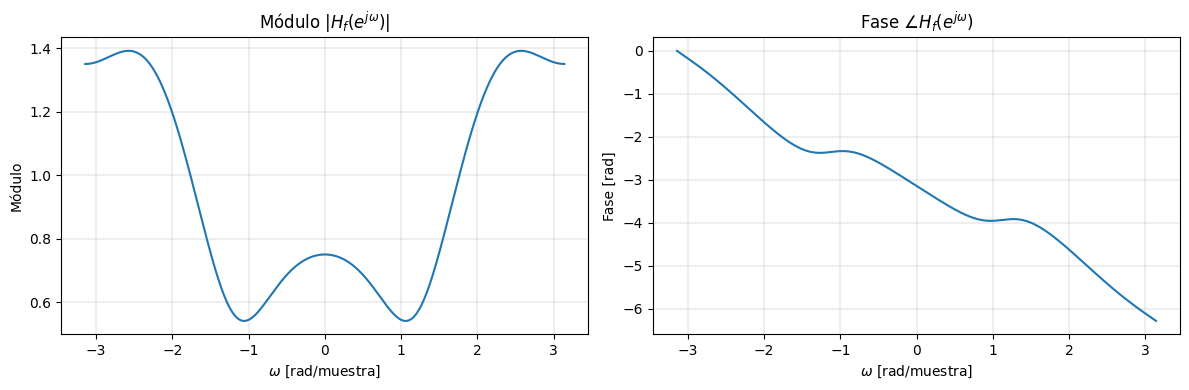

In [19]:
# --- Coeficientes LPC ficticios (ajustá a gusto) ---
a = np.array([0.90, -0.40, 0.20, 0.10, -0.05], dtype=float)  # M = 5

# --- Grilla de frecuencias ---
w = np.linspace(-np.pi, np.pi, 2048, endpoint=False)

# --- Evalúa Hf(e^{jω}) = -Σ a_k e^{-jωk} ---
k = np.arange(1, len(a)+1)                       # 1..M
E = np.exp(-1j * np.outer(w, k))                 # [len(w) x M]
Hf = -(E @ a)                                    # Hf(e^{jω})

# --- (Opcional) Evalúa A(e^{jω}) y verifica Hf = 1 - A ---
A = 1.0 + (E @ a)
err = np.max(np.abs(Hf - (1 - A)))

print(f"Chequeo identidad Hf = 1 - A  ->  error máximo = {err:.3e}")

# --- Gráficos: módulo y fase ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(w, np.abs(Hf))
plt.title(r'Módulo $|H_f(e^{j\omega})|$')
plt.xlabel(r'$\omega$ [rad/muestra]')
plt.ylabel('Módulo')
plt.grid(True, linewidth=0.3)

plt.subplot(1,2,2)
plt.plot(w, np.unwrap(np.angle(Hf)))
plt.title(r'Fase $\angle H_f(e^{j\omega})$')
plt.xlabel(r'$\omega$ [rad/muestra]')
plt.ylabel('Fase [rad]')
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

### Conclusión — Ejercicio 6

En los gráficos se observa la **respuesta en frecuencia del filtro predictor LPC**:

- El **módulo** $(|H_f(e^{j\omega})|)$ muestra variaciones periódicas que reflejan las frecuencias donde el predictor tiene mayor sensibilidad.  
- La **fase** $(\angle H_f(e^{j\omega}))$ desciende de manera aproximadamente lineal con la frecuencia, presentando quiebres asociados a los polos/ceros del sistema.

Esto confirma que el filtro predictor LPC puede representarse como un **FIR causal** cuya respuesta en frecuencia se obtiene analíticamente de los coeficientes LPC.  
La implementación numérica verifica la relación $( H_f(e^{j\omega}) = 1 - A(e^{j\omega}) )$, validando la coherencia entre el modelo analítico y su simulación computacional.

## Ejercicio 7 — Filtro **inverso del predictor** (solución analítica)

**Consigna.** Conocidos los coeficientes LPC $(\{a_k\}_{k=1}^M)$, hallar analíticamente
la respuesta en frecuencia $(H_i(e^{j\omega}))$ del filtro definido en (5), **con**
$(\hat{x}[t])$ como **entrada** y $(\hat{y}[t])$ como **salida**.

---

### 1) Punto de partida (del Ej. 4)
El **predictor LPC** (orden \(M\)) es un FIR con:
$$
h_f[n] = -\sum_{k=1}^{M} a_k\,\delta[n-k],
\qquad
H_f(z) = -\sum_{k=1}^{M} a_k z^{-k}.
$$

La señal predicha cumple
$$
\hat{x}[n] = (x * h_f)[n]
\quad\Longleftrightarrow\quad
\hat{X}(z)=H_f(z)\,X(z).
$$

---

### 2) Definición del filtro de (5)
Buscamos un filtro $(H_i)$ tal que, tomando $(\hat{x})$ como **entrada**, su salida $(\hat{y})$ recupere (idealmente) la señal original:
$$
\hat{y}[n] = (\,\hat{x} * h_i\,)[n],
\qquad
\hat{Y}(z)=H_i(z)\,\hat{X}(z).
$$

Para lograr \(\hat{Y}(z) = X(z)\) se requiere:
$$
H_i(z)\,H_f(z)=1
\ \ \Longrightarrow\ \
\boxed{\,H_i(z)=\dfrac{1}{H_f(z)}\,}.
$$

---

### 3) Respuesta en frecuencia (solución analítica)
Evaluando sobre la circunferencia unitaria $(z=e^{j\omega})$:
$$
\boxed{\;
H_i(e^{j\omega})=\frac{1}{H_f(e^{j\omega})}
= -\,\frac{1}{\displaystyle \sum_{k=1}^{M} a_k\,e^{-j\omega k}}
\; }.
$$

---

### 4) Observaciones de realizabilidad/estabilidad
- $(H_i(z))$ es un filtro **IIR** cuyos polos son las raíces de $(\sum_{k=1}^{M} a_k z^{-k}=0)$.
- Para que \(H_i\) sea **causal y estable**, ese polinomio debe ser **mínimo-fase**
  (todas sus ceros dentro del círculo unitario).  
  En caso contrario, la inversión exacta puede ser no causal o inestable.
- En la práctica de LPC, la **síntesis** suele realizarse excitando el filtro **all-pole**
  $(1/A(z))$ con el residuo; aquí, en cambio, $(H_i=1/H_f)$ es el **inverso del predictor**,
  específico de la relación $(\hat{x}=H_f x)$.

---

**Conclusión.** La solución analítica pedida es

$$
\boxed{\,H_i(e^{j\omega}) = -\left(\sum_{k=1}^{M} a_k\,e^{-j\omega k}\right)^{-1}},
$$

esto es, el **inverso** (en frecuencia) del filtro predictor del Ej. 4.


## Ejercicio 8 — Implementación (por ecuación en diferencias) del sistema de (5)

Queremos implementar el sistema cuyo **input** es $(\hat{x}[n])$ y **output** $(\hat{y}[n])$ definido en (5).
Del Ej. 7 sabemos que el filtro inverso del predictor cumple
$$
H_i(z)\,H_f(z)=1, \qquad
H_f(z)=-\sum_{k=1}^{M} a_k z^{-k}.
$$
Luego,
$$
H_i(z)=\frac{1}{H_f(z)}=
-\frac{1}{\sum_{k=1}^{M} a_k z^{-k}}.
$$

> Implementar este sistema **vía su respuesta impulsiva** no es conveniente $e (h_i[n])$ sería de **duración infinita**). En cambio, lo implementamos con su **ecuación en diferencias**.

### Derivación de la ecuación en diferencias (versión **causal** con retardo \(M\))
Multiplicamos por $(z^{M})$ para obtener un denominador con término constante:
$$
H_i(z)= -\frac{z^{-M}}{a_M + a_{M-1}z^{-1} + \cdots + a_1 z^{-(M-1)}}.
$$

En tiempo:
$$
a_M\,\hat{y}[n] + a_{M-1}\,\hat{y}[n-1] + \cdots + a_1\,\hat{y}[n-(M-1)]
= -\,\hat{x}[n-M].
$$

Por lo tanto, la **recursión causal** es
$$
\boxed{
\hat{y}[n] =
\frac{-\,\hat{x}[n-M]
-\displaystyle\sum_{j=1}^{M-1} a_{M-j}\,\hat{y}[n-j]}
{\,a_M\,}
}
$$

(para $(n\ge M)$; usar condiciones iniciales nulas u otras acordes).

> Observación: esta implementación introduce un **retardo \(M\)**, necesario para que la ecuación tenga término $(\hat{y}[n])$ y pueda computarse de forma causal y estable (si el polinomio es de mínima fase).

In [22]:
# Implementación con scipy.signal.lfilter
from scipy.signal import lfilter

def hi_filter_lfilter(xhat, a):
    """
    Implementación con lfilter.
    Hi(z) = (- z^{-M}) / (a_M + a_{M-1} z^{-1} + ... + a_1 z^{-(M-1)})
          =  B(z)/A(z), con A(z) normalizado a A[0]=1.
    -> A_norm(z) = 1 + (a_{M-1}/a_M) z^{-1} + ... + (a_1/a_M) z^{-(M-1)}
       B(z) = (-1/a_M) z^{-M}
    """
    a = np.asarray(a, dtype=float)
    M = len(a)
    if M == 0 or a[-1] == 0:
        raise ValueError("a_M no puede ser 0.")

    A = np.concatenate(([1.0], a[:-1][::-1] / a[-1]))  # [1, a_{M-1}/a_M, ..., a_1/a_M]
    B = np.zeros(M + 1)
    B[-1] = -1.0 / a[-1]                               # (-1/a_M) z^{-M}

    return lfilter(B, A, xhat)


In [ ]:
# a = [a1, ..., aM] obtenidos por LPC
# xhat = señal predicha del Ej. 4 (o el residuo filtrado que se haya definido como entrada en (5))
yhat_lf  = hi_filter_lfilter(xhat, a)